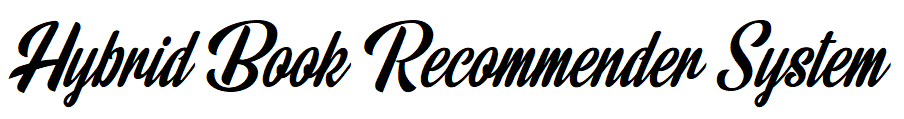

Recommender systems have become increasingly popular in the past few years. One of the most frequent problems faced when constructing a recommender system is the "cold start" problem. That is, how to make recommendations to a brand new user (who hasn't reviewed any items) or how to recommend a product that hasn't been reviewed by any users yet. One solution to this problem is the use of a hybrid recommender system, which combines collaborative filtering and content-based filtering.

I will use Ruchi Bhatia's Book-crossing dataset and the [LightFM package](https://making.lyst.com/lightfm/docs/home.html) to construct this system. In addition, I hope this notebook will serve as an example of LightFM's functions and how the usage of item and user feature matrices can help us build better and more accurate models.

# Data Preprocessing

1. Import necessary packages.

In [3]:
import numpy as np 
import pandas as pd
import pycountry
import matplotlib.pyplot as plt
import random
from random import sample 
from sklearn.preprocessing import MinMaxScaler
from lightfm import LightFM, cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import reciprocal_rank
from lightfm.data import Dataset
pd.options.mode.chained_assignment = None
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import seaborn as sns

2. Put each table of dataset in dataframe.

In [4]:
user_c = ['u_id', 'country', 'age']
users = pd.read_csv('../input/bookcrossing-dataset/Book reviews/BX-Users.csv', sep=';', names= user_c, encoding='latin-1',low_memory=False)

books_c = ['isbn', 'title', 'author', 'year_of_publication', 'publisher', 'img1', 'img2', 'img3']
books = pd.read_csv('../input/bookcrossing-dataset/Book reviews/BX_Books.csv', sep=';', names= books_c, encoding='latin-1',low_memory=False)

ratings_c = ['u_id', 'isbn', 'rating']
ratings = pd.read_csv('../input/bookcrossing-dataset/Book reviews/BX-Book-Ratings.csv', sep=';', names=ratings_c, encoding='latin-1',low_memory=False)


3. Get rid of all invalid data in frames and trim the location column so that it contains countries only. Delete all rows with user ages >90 and <5. Also drop image columns and first row from books and ratings datasets.


In [5]:
temp = users['country'].str.split(',', 3, expand = True)
users['country'] = temp[2]
users.drop(users.head(1).index, inplace = True)
index_null_feat = users[ users['country'] == '' ].index 
users.drop(index_null_feat, inplace = True) 

users.replace(to_replace = ['NaN', 'NaT'], value = np.nan, inplace = True)
users.dropna(how= 'any', inplace = True)

books.replace(to_replace = ['NaN', 'NaT'], value = np.nan, inplace = True)
books.dropna(how= 'any', inplace = True)

ratings.replace(to_replace = ['NaN', 'NaT'], value = np.nan, inplace = True)
ratings.dropna(how= 'any', inplace = True)

users.age = pd.to_numeric(users.age, errors = 'coerce').astype('Int64')
users = users.loc[(users.age >5) & (users.age < 90)]

books.drop('img1', axis=1, inplace=True)
books.drop('img2', axis=1, inplace=True)
books.drop('img3', axis=1, inplace=True)

books.drop(books.head(1).index, inplace = True)
ratings.drop(ratings.head(1).index, inplace = True)

# Data Analysis and Visualization

1. An overview of the dataframes.

In [ ]:
users.head()

In [ ]:
users.info()

In [ ]:
books.head()

In [ ]:
books.info()

In [ ]:
ratings.head()

In [ ]:
ratings.info()

2. Age and location distribution for users.

In [ ]:
color_palette = sns.color_palette("mako")

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(users['age'],kde=False, color =color_palette[1] )
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution',size=22)

In [ ]:
country_list=users['country'].value_counts().head(20).reset_index()
country_list.columns=['country','count']

plt.figure(figsize=(10,10))
sns.barplot(x='count',y='country',data=country_list, palette= color_palette)
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Location Distribution',size=20)

In [ ]:
temp1 = (country_list.loc[0,'count'] + country_list.loc[2, 'count'] + country_list.loc[3, 'count'])
temp = country_list.drop(index = [0, 2, 3], axis = 0).sum(axis = 0)
temp2 = temp.loc['count']
usa_others = pd.DataFrame([['USA, Canada and UK', temp1],['Others', temp2]], columns=['country','count'])

plt.figure(figsize=(10,3))
sns.barplot(x='count',y='country',data=usa_others, palette= color_palette)
plt.xlabel('Count')
plt.title('Location Distribution - USA, Canada and UK',size=20)

3. Ratings distribution, most rated books and authors, most popular publishers.

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating',data=ratings, palette = color_palette)
plt.title('Rating Distribution',size=20)

In [ ]:
tmp = pd.merge(ratings, books, on = 'isbn')
info_total = pd.merge(tmp, users, on = 'u_id')
info_total.rating = pd.to_numeric(info_total.rating, errors = 'coerce').astype('Int64')

In [ ]:
authors = info_total['author'].value_counts().head(20).reset_index()
authors.columns=['author','count']

plt.figure(figsize=(10,10))
sns.barplot(x='count',y='author',data=authors, palette = color_palette)
plt.xlabel('Count')
plt.ylabel('Author')
plt.title('Most Rated Authors',size=20)

In [ ]:
titles = info_total['title'].value_counts().head(20).reset_index()
titles.columns=['book','count']

plt.figure(figsize=(10,10))
sns.barplot(x='count',y='book',data=titles, palette = color_palette)
plt.xlabel('Count')
plt.ylabel('Book')
plt.title('Most Rated Books',size=20)

In [ ]:
publishers = info_total['publisher'].value_counts().head(20).reset_index()
publishers.columns=['publisher','count']

plt.figure(figsize=(10,10))
sns.barplot(x='count',y='publisher',data=publishers, palette = color_palette)
plt.xlabel('Count')
plt.ylabel('Publisher')
plt.title('Most Popular Publishers',size=20)

4. Most popular books by age range and country.

In [ ]:
#books must be rated at least a 5 to be included
reviews_5_to_13 = info_total[(info_total['age'] > 4) & (info_total['age'] <= 13) & (info_total['rating'] > 4)]
reviews_14_to_21 = info_total[(info_total['age'] > 13) & (info_total['age'] <= 22)& (info_total['rating'] > 4)]
reviews_22_to_35 = info_total[(info_total['age'] > 22) & (info_total['age'] <= 35)& (info_total['rating'] > 4)]
reviews_36_to_50 = info_total[(info_total['age'] > 35) & (info_total['age'] <= 50)& (info_total['rating'] > 4)]
reviews_51_to_65 = info_total[(info_total['age'] > 50) & (info_total['age'] <= 65)& (info_total['rating'] > 4)]
reviews_66_plus = info_total[(info_total['age'] > 65)& (info_total['rating'] > 4)]

In [ ]:
block_1 = reviews_5_to_13['title'].value_counts().head(20).reset_index()
block_1.columns=['title','count']

block_2 = reviews_14_to_21['title'].value_counts().head(20).reset_index()
block_2.columns=['title','count']

block_3 = reviews_22_to_35['title'].value_counts().head(20).reset_index()
block_3.columns=['title','count']

block_4 = reviews_36_to_50['title'].value_counts().head(20).reset_index()
block_4.columns=['title','count']

block_5 = reviews_51_to_65['title'].value_counts().head(20).reset_index()
block_5.columns=['title','count']

block_6 = reviews_66_plus['title'].value_counts().head(20).reset_index()
block_6.columns=['title','count']


In [ ]:
plt.figure(figsize=(12,12))
sns.barplot(x='count',y='title',data=block_1, palette = color_palette)
plt.xlabel('Number of Reviews')
plt.ylabel('Title')
plt.title('Most Popular Books for Ages < 13',size=20)

In [ ]:
plt.figure(figsize=(12, 12))
sns.barplot(x='count',y='title',data=block_2, palette = color_palette)
plt.xlabel('Number of Reviews')
plt.ylabel('Title')
plt.title('Most Popular Books for Ages 14 - 21',size=20)

In [ ]:
plt.figure(figsize=(12, 12))
sns.barplot(x='count',y='title',data=block_3, palette = color_palette)
plt.xlabel('Number of Reviews')
plt.ylabel('Title')
plt.title('Most Popular Books for Ages 22 - 35',size=20)

In [ ]:
plt.figure(figsize=(12, 12))
sns.barplot(x='count',y='title',data=block_4, palette = color_palette)
plt.xlabel('Number of Reviews')
plt.ylabel('Title')
plt.title('Most Popular Books for Ages 36 - 50',size=20)

In [ ]:
plt.figure(figsize=(12,12))
sns.barplot(x='count',y='title',data=block_5, palette = color_palette)
plt.xlabel('Number of Reviews')
plt.ylabel('Title')
plt.title('Most Popular Books for Ages 51 - 65',size=20)

In [ ]:
plt.figure(figsize=(12,12))
sns.barplot(x='count',y='title',data=block_6, palette = color_palette)
plt.xlabel('Number of Reviews')
plt.ylabel('Title')
plt.title('Most Popular Books for Ages > 66',size=20)

In [ ]:
options = country_list['country']

In [ ]:
for option in options:
    print(option)
    a = info_total[(info_total['country'] == option) & (info_total['rating'] > 3)]
    b = a['title'].value_counts().head(3).reset_index()
    b.columns = ['title', 'count']
    print(b.title.to_string(index=False))

# Building LighFM Dataset

1. Create list of user IDs.

In [6]:
#to create interactions matrix later
ratings2 = pd.merge(ratings, books, on = 'isbn')
ratings4 =pd.merge(ratings, books, on = 'isbn')
#to create user features matrix later
ratings3 = pd.merge(ratings, users, on = 'u_id')
ratings5 = pd.merge(ratings, users, on = 'u_id')

2. Create list of book IDs (ISBN).

In [7]:
user_list = list(ratings2.u_id.unique())

In [8]:
book_list = list(ratings2.isbn.unique())

3. Create list with all possible feature options for a user (ex. for some user ['23', 'USA']).

In [9]:
all_countries = list(users.country.unique())
user_feature_list = all_countries
user_feature_list.extend(list(users.age.unique()))

4. Create list with all possible feature options for a book.

In [10]:
all_authors = list(books.author.unique())
all_publishers = list(books.publisher.unique())
publication_years = list(books.year_of_publication.unique())
book_feature_list = all_authors
book_feature_list.extend(all_publishers)
book_feature_list.extend(publication_years)

5. Create and fit LightFM dataset.

In [11]:
dataset = Dataset()
dataset.fit(user_list, book_list, user_feature_list, book_feature_list)

# Building Interactions and Feature Matrices

1. Create user -> book mapping matrix. Must be in the form of [user_ID, ISNB] for every user/book interaction.

In [12]:
user_col = ratings2['u_id'].tolist()
book_col = ratings2['isbn'].tolist()
user_book_int = zip(user_col, book_col)

2. Create interactions matrix.

In [13]:
interactions, weigths = dataset.build_interactions(user_book_int)

3. Create list of tuples of the form (ISBN, ['author', 'publisher', 'publication_year'])

In [14]:
ratings2.drop('u_id', axis=1, inplace=True)
ratings2.drop('isbn', axis=1, inplace=True)
ratings2.drop('rating', axis=1, inplace=True)
ratings2.drop('title', axis=1, inplace=True)
ratings4['features'] = ratings2.values.tolist()

In [15]:
ratings4.drop_duplicates(subset = ['isbn'])
feature_pairs = ratings4['features'].tolist()
book_feature_pairs = zip(book_list, feature_pairs)

4. Create list of tuples of the form (user ID, ['age', 'country'])

In [16]:
ratings3.drop('u_id', axis=1, inplace=True)
ratings3.drop('isbn', axis=1, inplace=True)
ratings3.drop('rating', axis=1, inplace=True)
ratings5['features'] = ratings3.values.tolist()

In [17]:
ratings5.drop_duplicates(subset = ['u_id'])
feature_pairs = ratings5['features'].tolist()
user_feature_pairs = zip(user_list, feature_pairs)

5. Create book and user feature matrices.

In [18]:
book_features = dataset.build_item_features(book_feature_pairs)

In [19]:
user_features = dataset.build_user_features(user_feature_pairs)

# Create and Train Model

1. Initialize model.

In [20]:
model = LightFM(learning_rate=0.05, loss='warp')

2. Split data into train and test sets.

In [21]:
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=None)

3. Fit model using interactions and feature matrices.

In [22]:
model.fit(train, user_features, book_features, epochs = 5, verbose = True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


# Evaluate Model

1. Precision at k.

In [ ]:
model_precision_at_k = precision_at_k(model, test,train, k=20, user_features = user_features,item_features = book_features).mean()
print('model precision at k = 100 : '+ str(model_precision_at_k) +'/1')

2. Recall at k.

In [ ]:
model_recall_at_k = recall_at_k(model, test,train,  k=20, user_features = user_features,item_features = book_features).mean()
print('model recall at k = 20 : '+ str(model_recall_at_k)+'/1')

3. AUC score.

In [ ]:
model_auc_score = auc_score(model, test, train, user_features, book_features).mean()
print('model AUC score : ' + str(model_auc_score)+'/1')

4. Reciprocal rank.

In [ ]:
model_reciprocal_rank = reciprocal_rank(model, test, train, user_features, book_features).mean()
print('model average reciprocal rank : ' + str(model_reciprocal_rank)+'/1')

# Make Predictions

1. Create function to make and display predictions.

In [ ]:
#I will modify the original function to accomodate having/not having user and item feature matrices later. For now I'll just make a new one
def test_predictions2(model, data, user_ids, user_features, book_features, rating_threshold, num_pred, book_dict, user_dict):
    num_users, num_items = data.shape
    
    for user_id in user_ids:
        u_id = user_dict[user_id]
        scores = pd.Series(model.predict(u_id, np.arange(num_items),item_features=book_features, user_features=user_features))
        scores.index = data.columns
        scores = list(pd.Series(scores.sort_values(ascending=False).index))
        known_items = list((pd.Series(data.loc[user_id,:][data.loc[user_id,:] > (rating_threshold)]).index).sort_values(ascending=False))
        scores = [x for x in scores if x not in known_items]
        return_score_list = scores[0:num_pred]
        known_items = list(pd.Series(known_items).apply(lambda x: book_dict[x]))
        scores = list(pd.Series(return_score_list).apply(lambda x: book_dict[x]))
        known_likes = known_items[0:num_pred]
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_likes:
            print(str(counter) + '- ' + i)
            counter+=1
        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

In [ ]:
book_dict = {}
df = ratings2[['isbn', 'title']].sort_values('isbn').reset_index()
for i in range(df.shape[0]):
    book_dict[(df.loc[i,'isbn'])] = df.loc[i,'title']

user_dict = {}
user_ids = list(b_ratings.index)
counter = 0
for user_id in user_ids:
    user_dict[user_id] = counter
    counter +=1

2. Get sample predictions.